# Baby Neural Turing Machines

In [1]:
# Import libraries and relevant dependencies
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import string
from torch.autograd import Variable

# Dyck library
from tasks.dyck_generator import DyckLanguage

# RNN Models
from models.ntm_models import BNTM_Softmax, BNTM_SoftmaxTemperature, BNTM_GumbelSoftmax

# Set default tensor type "double"
torch.set_default_tensor_type('torch.DoubleTensor')

#### Fix the random seed:

In [2]:
randomseed_num = 1729
print ('RANDOM SEED: {}'.format(randomseed_num))
random.seed (randomseed_num)
np.random.seed (randomseed_num)
torch.manual_seed(randomseed_num)

RANDOM SEED: 1729


#### GPU/CPU Checkpoint

In [3]:
# GPU/CPU Check
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ## GPU stuff
print (device)

cpu


## Dyck Languages

A probabilistic context-free grammar for $\mathcal{D}_n$ can be written as follows:

\begin{align*}
S \rightarrow \begin{cases} 
(_i\, S\, )_i & \text{with probability } \frac{p}{n} \\
S\,S & \text{with probability } q \\ 
\varepsilon & \text{with probability } 1 - (p+q) 
\end{cases}
\end{align*}
where $0 < p, q < 1$ and $p+q < 1$.

### Training and Test Corpora Generation

Training corpus window : [`MIN_SIZE`, `MAX_SIZE`]

Test corpus window: [`MAX_SIZE+2`, `2*MAX_SIZE`]

In [4]:
## Parameters of the Probabilistic Dyck Language 
NUM_PAR = 2
MIN_SIZE = 2
MAX_SIZE = 50
P_VAL = 0.5
Q_VAL = 0.25

# Number of samples in the training corpus
TRAINING_SIZE = 5000
# Number of samples in the test corpus
TEST_SIZE = 5000

# Create a Dyck language generator
Dyck = DyckLanguage (NUM_PAR, P_VAL, Q_VAL)
all_letters = word_set = Dyck.return_vocab ()
n_letters = vocab_size = len (word_set)

print('Loading data...')

training_input, training_output, st = Dyck.training_set_generator (TRAINING_SIZE, MIN_SIZE, MAX_SIZE)
test_input, test_output, st2 = Dyck.training_set_generator (TEST_SIZE, MAX_SIZE + 2, 2 * MAX_SIZE)

for i in range (1):
    print (training_input[i])
    print (training_output[i])
    print (Dyck.lineToTensor(training_input[i]))
    print (Dyck.lineToTensorSigmoid(training_output[i]))
    print (test_input[i])
    print (test_output[i])

Loading data...
500 samples generated.
1000 samples generated.
1500 samples generated.
2000 samples generated.
2500 samples generated.
3000 samples generated.
3500 samples generated.
4000 samples generated.
4500 samples generated.
5000 samples generated.
500 samples generated.
1000 samples generated.
1500 samples generated.
2000 samples generated.
2500 samples generated.
3000 samples generated.
3500 samples generated.
4000 samples generated.
4500 samples generated.
5000 samples generated.
[([[[]]]())]
212222211120
tensor([[[0., 0., 1., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 1.]],

        [[0., 0., 0., 1.]],

        [[0., 0., 0., 1.]],

        [[1., 0., 0., 0.]],

        [[0., 1., 0., 0.]],

        [[0., 1., 0., 0.]],

        [[0., 0., 0., 1.]]])
tensor([[1., 0., 1., 1.],
        [1., 1., 1., 0.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
  

### Baby-NTM  Parameters

In [5]:
# Number of hidden units
n_hidden = 12
# Number of hidden layers
n_layers = 1
# Memory size
memory_size = 104
memory_dim = 5

# Parameters for the temperature-based methods
temp = 1.0
temp_min = 0.5
ANNEAL_RATE = .00001

In [6]:
## Stack-RNN with Softmax
model = BNTM_Softmax (n_hidden, vocab_size, vocab_size, n_layers, memory_size, memory_dim).to(device)
# Learning rate
learning_rate = .01
# Minimum Squared Error (MSE) loss
criterion = nn.MSELoss() 
# Adam optimizer (https://arxiv.org/abs/1412.6980)
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [7]:
print ('Model details:')
print (model)

Model details:
BNTM_Softmax(
  (rnn): RNN(4, 12)
  (W_m): Linear(in_features=5, out_features=12, bias=True)
  (W_y): Linear(in_features=12, out_features=4, bias=True)
  (W_n): Linear(in_features=12, out_features=5, bias=True)
  (W_a): Linear(in_features=12, out_features=5, bias=True)
  (softmax): Softmax(dim=0)
  (sigmoid): Sigmoid()
)


In [8]:
# Number of epochs to train our model
epoch_num = 5
# Output threshold
epsilon = 0.5

### Training and Testing the Stack-RNN Model

In [9]:
def test_model (model, data_input, data_output):
    # Turn on the eval mode
    model.eval()
    # Total number of "correctly" predicted samples
    correct_num = 0
    with torch.no_grad():
        for i in range (len(data_output)):
            len_input = len (data_input[i])
            model.zero_grad ()
            # Initialize the hidden state
            hidden = model.init_hidden()
            # Initialize the memory
            memory = torch.zeros (memory_size, memory_dim).to(device)
            # Target values
            target = Dyck.lineToTensorSigmoid(data_output[i]).to(device) 
            # Output values
            output_vals = torch.zeros (target.shape)
            
            for j in range (len_input):
                output, hidden, memory = model (Dyck.lineToTensor(data_input[i][j]).to(device), hidden, memory)
                output_vals [j] = output

            # Binarize the entries based on the output threshold
            out_np = np.int_(output_vals.detach().numpy() >= epsilon)
            target_np = np.int_(target.detach().numpy())
            
            # (Double-)check whether the output values and the target values are the same
            if np.all(np.equal(out_np, target_np)) and (out_np.flatten() == target_np.flatten()).all():
                # If so, increase `correct_num` by one
                correct_num += 1
                
    return float(correct_num)/len(data_output) * 100, correct_num

In [10]:
def train (model, optimizer, criterion, epoch_num=3):
    # Turn on the train model for the model
    model.train()
    # Arrays for loss and "moving" accuracy per epoch
    loss_arr = []
    correct_arr = []
    for epoch in range(1, epoch_num + 1):
        print ('Epoch: {}'.format(epoch))
        
        # Total loss per epoch
        total_loss = 0
        # Total number of "correctly" predicted samples so far in the epoch
        counter = 0

        for i in range (TRAINING_SIZE):
            len_input = len (training_input[i])
            # Good-old zero grad
            model.zero_grad ()
            # Initialize the hidden state
            hidden = model.init_hidden()
            # Initialize the memory 
            memory = torch.zeros (memory_size, memory_dim).to(device)
            # Target values
            target = Dyck.lineToTensorSigmoid(training_output[i]).to(device) 
            # Output values
            output_vals = torch.zeros (target.shape)

            for j in range (len_input):
                output, hidden, memory = model (Dyck.lineToTensor(training_input[i][j]).to(device), hidden, memory)
                output_vals [j] = output
            
            # MSE (y, y_bar)
            loss = criterion (output_vals, target)
            # Add the current loss to the total loss
            total_loss += loss.item()
            # Backprop! 
            loss.backward ()
            optimizer.step ()
            
            # Print the performance of the model every 500 steps
            if i % 250 == 0:
                print ('Sample Number {}: '.format(i))
                print ('Input : {}'.format(training_input[i]))
                print ('Output: {}'.format(training_output[i]))
                print ('* Counter: {}'.format(counter))
                print ('* Avg Loss: {}'.format(total_loss/(i+1))) 

            # Binarize the entries based on the output threshold
            out_np = np.int_(output_vals.detach().numpy() >= epsilon)
            target_np = np.int_(target.detach().numpy())
                
            # "Moving" training accuracy
            if np.all(np.equal(out_np, target_np)) and (out_np.flatten() == target_np.flatten()).all():
                counter += 1
                
            # At the end of the epoch, append our total loss and "moving" accuracy
            if i == TRAINING_SIZE - 1:
                print ('Counter: {}'.format(float(counter)/TRAINING_SIZE))
                loss_arr.append (total_loss)
                correct_arr.append(counter) 

        if epoch % 1 == 0:
            print ('Training Accuracy %: ', correct_arr)
            print ('Loss: ', loss_arr)

#### Let there be light!

In [11]:
train (model, optim, criterion, epoch_num)

Epoch: 1
Sample Number 0: 
Input : [([[[]]]())]
Output: 212222211120
* Counter: 0
* Avg Loss: 0.28577524031818285
Sample Number 250: 
Input : [[[(()([[(())]]))]]]
Output: 22211112211122112220
* Counter: 1
* Avg Loss: 0.0837031479525154
Sample Number 500: 
Input : ([(()(()))])
Output: 121111111210
* Counter: 7
* Avg Loss: 0.06505831459496109
Sample Number 750: 
Input : [(([[]])[[][]])]
Output: 2112221122222120
* Counter: 31
* Avg Loss: 0.05563432172454156
Sample Number 1000: 
Input : [[[[]][[]]]]
Output: 222222222220
* Counter: 57
* Avg Loss: 0.04954909904902164
Sample Number 1250: 
Input : [([[((()))]])]
Output: 21221111122120
* Counter: 234
* Avg Loss: 0.04096930254240002
Sample Number 1500: 
Input : [(([([])([[[[[(())[]]]]]])]()[()]))()][([()]([]))]
Output: 21121212122222111222222212111212112120212121121120
* Counter: 478
* Avg Loss: 0.03440341456924498
Sample Number 1750: 
Input : (([([])]))(())
Output: 11212121101110
* Counter: 711
* Avg Loss: 0.02972583457456173
Sample Number 2000

Counter: 1.0
Training Accuracy %:  [3961, 5000, 5000]
Loss:  [52.354061373115464, 0.027094410170337646, 0.0015958646551512323]
Epoch: 4
Sample Number 0: 
Input : [([[[]]]())]
Output: 212222211120
* Counter: 0
* Avg Loss: 5.3298557344247174e-08
Sample Number 250: 
Input : [[[(()([[(())]]))]]]
Output: 22211112211122112220
* Counter: 250
* Avg Loss: 6.240215271955903e-08
Sample Number 500: 
Input : ([(()(()))])
Output: 121111111210
* Counter: 500
* Avg Loss: 5.6709140709256964e-08
Sample Number 750: 
Input : [(([[]])[[][]])]
Output: 2112221122222120
* Counter: 750
* Avg Loss: 5.237454204366951e-08
Sample Number 1000: 
Input : [[[[]][[]]]]
Output: 222222222220
* Counter: 1000
* Avg Loss: 4.892151193153148e-08
Sample Number 1250: 
Input : [([[((()))]])]
Output: 21221111122120
* Counter: 1250
* Avg Loss: 4.576648886522762e-08
Sample Number 1500: 
Input : [(([([])([[[[[(())[]]]]]])]()[()]))()][([()]([]))]
Output: 21121212122222111222222212111212112120212121121120
* Counter: 1500
* Avg Loss: 4

### Evaluate the Performance of the Stack-RNN Model

In [12]:
# Training set accuracy 
correct_num = test_model (model, training_input, training_output)
print ('Training accuracy: {}.'.format(correct_num))

Training accuracy: (100.0, 5000).


In [13]:
# Test set accuracy 
correct_num = test_model (model, test_input, test_output)
print ('Test accuracy: {}.'.format(correct_num))

Test accuracy: (100.0, 5000).


### Save/Upload the Model Weights

In [14]:
# Save the model weights
torch.save(model.state_dict(), 'models/baby_ntm_model_weights.pth')

In [15]:
## Load the model weights
# model.load_state_dict(torch.load('models/baby_ntm_model_weights.pth'))

## Visualize the Memory Entires of a Baby-NTM

In [16]:
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
import plotly.graph_objs as go
import math

import seaborn as sns; sns.set()

import matplotlib
import matplotlib.pyplot as plt

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

### Get the Hidden State and Memory Configuration for a Given Input

In [17]:
def get_hidden_and_memory_info (model, input, output):
    # Turn on the evaluation mode for the model
    model.eval()
    # Hidden state values
    hidden_states = []
    # Memory configuration
    memory_config = []
    # Memory operation weights
    operation_weights = []
    # Most recently inserted element to the memory
    new_elt_inserted = []
    
    with torch.no_grad():
        len_input = len (input)
        model.zero_grad ()
        
        # Initialize the hidden state
        hidden = model.init_hidden()
        # Initalize the memory configuration
        memory = torch.zeros (memory_size, memory_dim).to(device)
        # Target values
        target = Dyck.lineToTensorSigmoid(output)
        # Output values
        output_vals = torch.zeros (target.shape).to(device)

        for j in range (len_input):
            # Feed the input to the model
            output, hidden, memory = model (Dyck.lineToTensor(input[j]).to(device), hidden, memory)
            # Hidden state values
            hidden_states.append (hidden.cpu().numpy())
            # Stack configuration 
            memory_config.append (memory.cpu().numpy())
            # Stack operation weights
            operation_weights.append (model.action_weights.cpu().numpy())
            # New element inserted to the stack
            new_elt_inserted.append (model.new_elt.cpu().numpy())
            # Output value
            output_vals [j] = output.view(-1)
        
        # Binarize the entries based on the output threshold
        out_np = np.int_(output_vals.cpu().detach().numpy() >= epsilon)
        target_np = np.int_(target.cpu().detach().numpy())
        
        # (Double-)check whether the output values and the target values are the same
        if np.all(np.equal(out_np, target_np)) and (out_np.flatten() == target_np.flatten()).all():
            print ('Correct!')
        else:
            print ('Incorrect')
            
    return hidden_states, memory_config, operation_weights, new_elt_inserted

In [18]:
input_seq = '(([[]]))[[(())]]()[]'
output_seq =  Dyck.output_generator (input_seq)

In [19]:
hidden_states, memory_config, operation_weights, new_elt_inserted = get_hidden_and_memory_info (model, input_seq, output_seq)

Correct!


### Visualize the Memory Operation Weights at Each Timestep

In [20]:
def visualize_memory_operation_weights (operation_weights, input_seq, timestep=1):
    # Stack operation labels
    labels = ['ROTATE LEFT','ROTATE RIGHT', 'NO-MOVE', 'POP-RIGHT', 'POP-LEFT']
    memory_op_weights = np.squeeze(operation_weights)
    plt.figure(figsize=(16, 5))
    fig = sns.heatmap(memory_op_weights.T, cmap=sns.light_palette("#34495e"),xticklabels=input_seq, yticklabels=labels, vmin=0, vmax=1)
    fig.set_title('Strength of Memory Operations at Each Timestep', fontsize=17)
    cbar = fig.collections[0].colorbar
    cbar.set_ticks(np.linspace(0,1,6))
    plt.xlabel('Sequence', fontsize=16)
    plt.ylabel('Actions', fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=14)
    # plt.savefig('weight_{}.png'.format(timestep), dpi=128, bbox_inches='tight')
    plt.show()

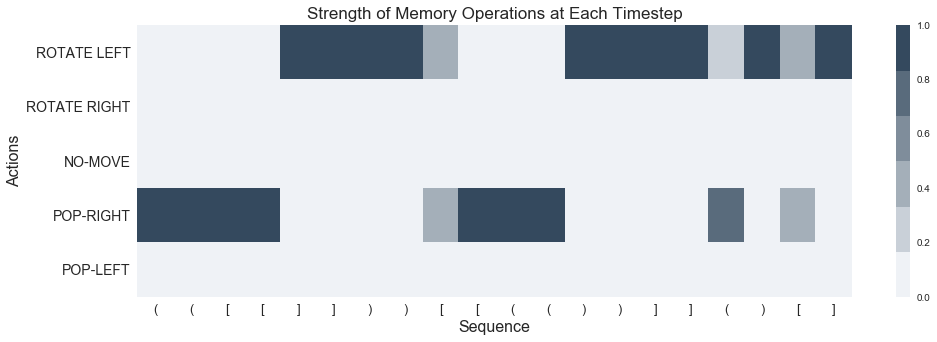

In [21]:
visualize_memory_operation_weights (operation_weights, input_seq)

### Visualize the Memory Configuration at Each Timestep

In [22]:
def visualize_memory_configuration (memory_config, input, dimension=0):
    memory_bound = 5
    first_half = np.round(np.array(memory_config)[:, :memory_bound+1, dimension], decimals=3)
    memory_config = np.concatenate((first_half, np.round(np.array(memory_config)[:, -(memory_bound+1):, dimension], decimals=3)), axis=1)
    location = np.concatenate((np.arange (1, memory_bound+2), np.arange (memory_size-(memory_bound), memory_size+1))) 
    plt.figure(figsize=(34, 20))
    fig = sns.heatmap(memory_config.T, cmap='viridis', yticklabels = location, xticklabels=input, annot=True, cbar=False)
    fig.invert_yaxis()
    fig.set_title('Memory Entries at Each Timestep', fontsize=17)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Sequence', fontsize=16)
    plt.ylabel('Memory Location', fontsize=16)
    plt.show()

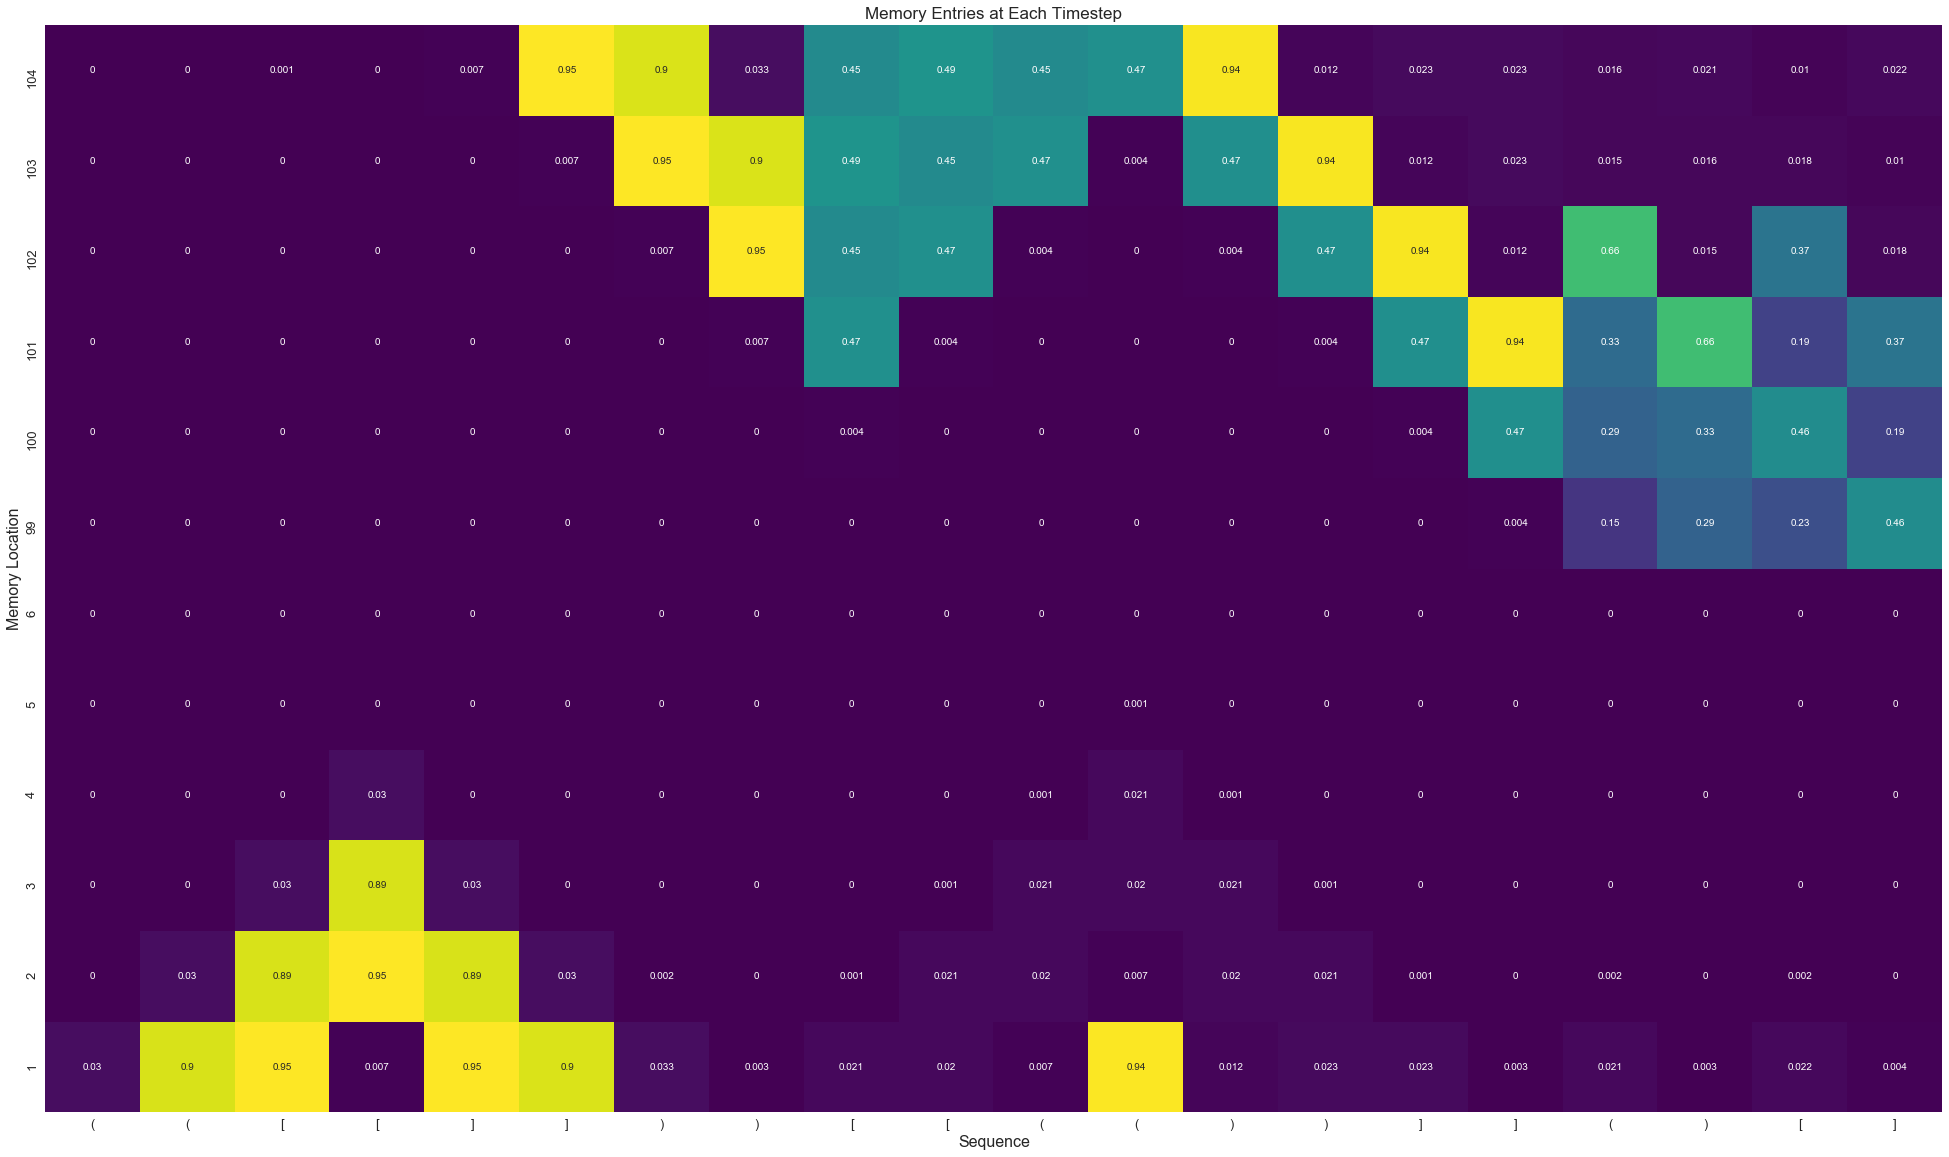

In [28]:
visualize_memory_configuration (memory_config, input_seq, 2)

### Visualize the Hidden State Values at Each Timestep

In [29]:
def visualize_hidden_states (hidden_states, input):
    plt.style.use('default')
    domain = list(range(len(input)))
    hidden_states = np.squeeze(hidden_states).T
    for i in range (int(n_hidden/2)):
        plt.figure()
        for j in range (2):
            plt.plot (domain, hidden_states[i*2+j], label='Unit {}'.format(i*2+j+1))
        plt.legend (loc='upper right')
        plt.xticks(domain, input_seq) 
        plt.title ('Analysis of the Hidden State Dynamics')
        plt.ylabel ('Activation Values')
        plt.ylim (-1.15, 1.15, 10)
        plt.show()

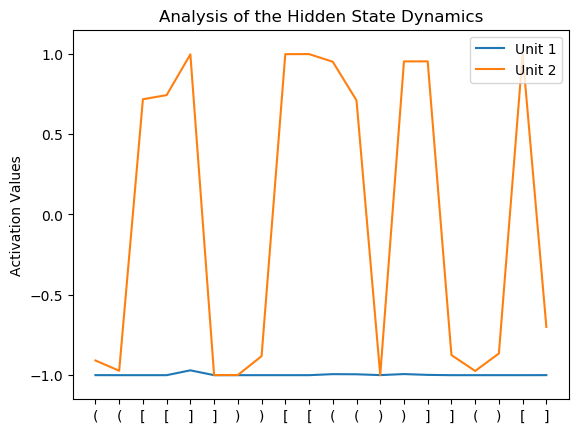

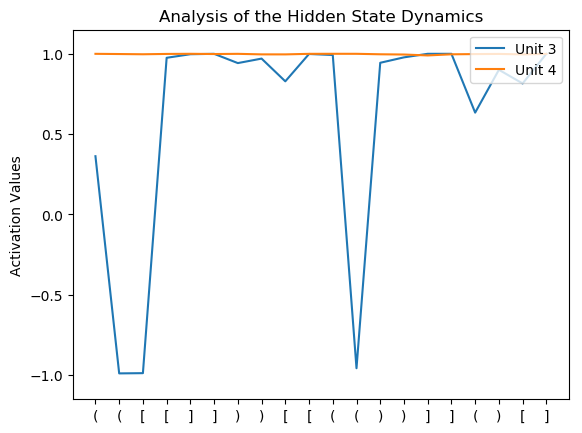

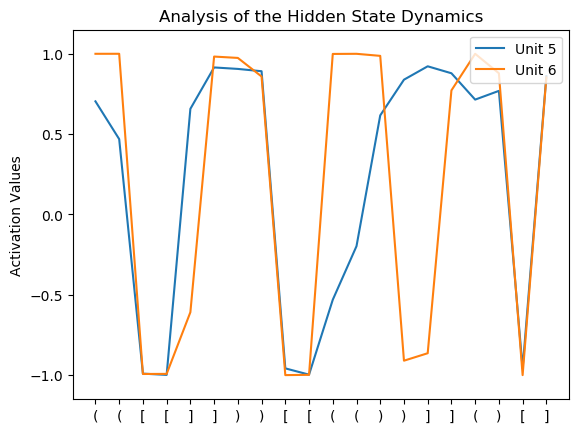

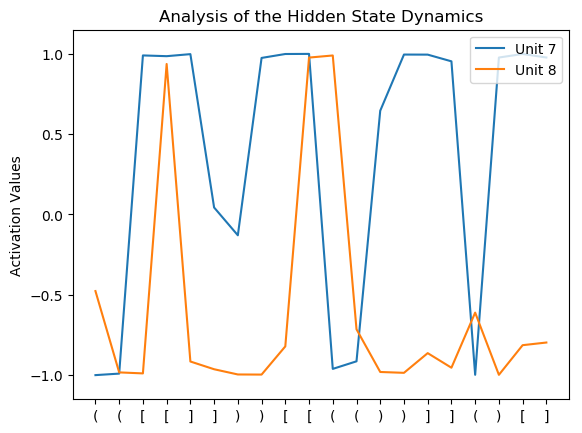

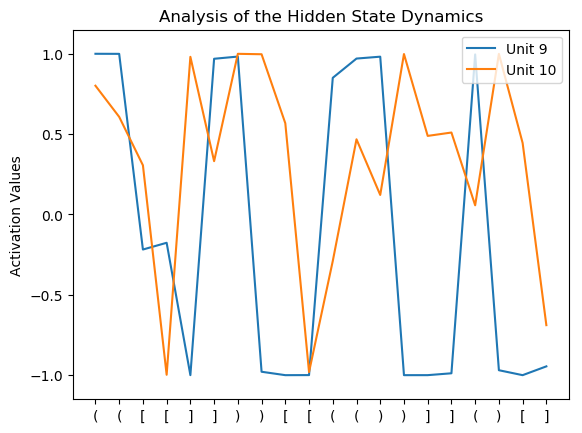

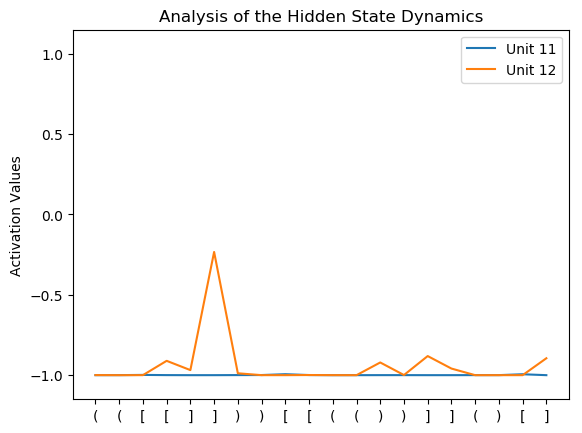

In [30]:
visualize_hidden_states (hidden_states, input_seq)

In [31]:
# Q.E.D.